In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io 
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, cv2

# packages needed for making a dataset: 
from torch.utils.data import DataLoader
from torchvision import transforms

from diffuser_utils import *
import dataset as ds
import models.spectral_model as sm
import models.machinelearning_forward as fm

from datetime import date, datetime

import sys
sys.path.append("..")

from models.unet import Unet
import models.unet3d as unet3d


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import dataset_helper_functions.read_pca_data as rpca
import csv

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" #choose the number of gpu that's free. It goes from 0-3

device = 'cuda:0'

In [3]:
# define fwd model
mask = load_mask()
num_images = 1
num_inputs_simult = 3
blur_type = 'asymmetric'
optimize_blur = False
forward_model = fm.Forward_Model(mask, num_ims = num_inputs_simult, blur_type = blur_type, cuda_device = device)

optimize blur False


AxesImage(54,36;334.8x217.44)


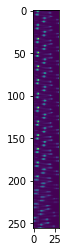

In [12]:
print(plt.imshow(mask[0]))

In [4]:
def fft_psf(h):
    h_complex = pad_zeros_torch(forward_model,torch.complex(h,torch.zeros_like(h)))
    H = torch.fft.fft2(torch.fft.ifftshift(h_complex)).unsqueeze(1)
    return H
def fft_im(im):
    xc = torch.complex(im, torch.zeros_like(im))  
    Xi = torch.fft.fft2(xc)    
    return Xi
def tt(x):
    return torch.tensor(x, dtype = torch.float32, device = device)

In [13]:
#x = np.zeros((2, 64, mask.shape[0]*2, mask.shape[1]*2))
#x[:,10:20, mask.shape[0], mask.shape[1]]=1

x = np.random.randn(2, 30, mask.shape[0]*2, mask.shape[1]*2)
y = np.random.randn(2, 3, mask.shape[0], mask.shape[1])
print(x.shape, y.shape)

forward_model.Xi = fft_im(tt(x)).unsqueeze(0)
forward_model.psfs = forward_model.make_psfs()
y_tilda = forward_model.Hfor().detach().cpu().numpy()
print('y_tilda shape:',y_tilda.shape)

x_tilda = forward_model.Hadj(tt(y)).detach().cpu().numpy()
print('x_tilda shape:',x_tilda.shape)

print((y[0][0].ravel()).dot(y_tilda[0][0].ravel()))
print((x[0].ravel()).dot(x_tilda[0][0].ravel()))

print((y.ravel()).dot(y_tilda.ravel()))
print((x.ravel()).dot(x_tilda.ravel()))



(2, 30, 512, 512) (2, 3, 256, 256)
y_tilda shape: (2, 3, 256, 256)
x_tilda shape: (2, 3, 30, 512, 512)
-138.5329930134288
-138.5329924658535
-65.93617710174107


ValueError: shapes (15728640,) and (47185920,) not aligned: 15728640 (dim 0) != 47185920 (dim 0)

In [ ]:
f = forward_model
adj = f.Hadj
base_x = torch.rand((1, 2, 30, 512, 512))
base_y = torch.unsqueeze(torch.rand((2, 256, 256)),0)
#base_x = np.random.randn(320*2, 460*2, 64)
#base_y = np.random.rand(320,460)

y_tilde = f(base_x.to(device)).detach().cpu().numpy()
x_tilde = adj(base_y.to(device), f.psf, 1).detach().cpu().numpy()
print(y_tilde.shape, x_tilde.shape)




print(base_y.shape)
x_vector = np.ravel(base_x.detach().cpu().numpy())
y_vector = np.ravel(base_y.detach().cpu().numpy())
print(y_vector.shape)

y_tilde_vector = np.ravel(y_tilde[0])
x_tilde_vector = np.ravel(x_tilde)


out1 = y_tilde_vector.dot(y_vector)
out2 = x_vector.dot(x_tilde_vector)
print(out1, out2)


In [ ]:
f = forward_model
# x and y
base_x = torch.rand((30, 512, 512))
base_y = torch.unsqueeze(torch.rand((2, 256, 256)),0)
x_vector = torch.ravel(base_x).float()
y_vector = torch.ravel(base_y)
print(y_vector.shape, x_vector.shape)

# y~ = Ax and x~ = A'y
y_tilde = f(base_x.to(device))[0]
x_tilde = f.Hadj(base_y.to(device), f.psf[0][np.newaxis], 1)[0][0]
y_tilde_vector = torch.ravel(y_tilde)


# y' and x~' = (A'y)'
y_transpose = torch.transpose(base_y[0], 1, 2).to(device)
x_tilde_transpose = torch.transpose(x_tilde, 1, 2).to(device)

x_tilde_transpose_vector = torch.ravel(x_tilde_transpose).float()
y_transpose_vector = torch.ravel(y_transpose)
print(x_tilde.shape, x_tilde_transpose.shape, x_tilde_transpose_vector.shape)
print(base_y.shape, y_transpose.shape)
print(y_tilde_vector.shape, y_transpose_vector.shape)

# asserting that: y' * y~ = x~' * x
print(torch.dot(y_transpose_vector, y_tilde_vector))
print(torch.dot(x_tilde_transpose_vector, x_vector.to(device)))
#print(result)

